# Part 5: Backtesting & Performance Evaluation

## Objectives
This notebook implements professional backtesting and performance evaluation for hedged and unhedged portfolios. The workflow includes:

- **Transaction Cost Implementation:** Apply realistic costs (5 bps per equity trade, 3 bps per SPY hedge)
- **Performance Metrics Calculation:** Compute comprehensive risk-adjusted metrics
- **Comparative Analysis:** Compare hedged vs. unhedged performance
- **Visualization:** Create clear, insightful charts
- **Commentary:** Provide concise interpretation of results

**Tasks:**
1. Apply transaction costs to both portfolios
2. Compute and compare all required performance metrics

**Deliverables:**
- Metrics DataFrame for both portfolios
- Markdown summary table
- Visual plots (Rolling Sharpe, return histograms, drawdown, VaR/CVaR)
- 300–400 word professional commentary


## 1. Import Libraries and Load Portfolio Data

Import required libraries and load the hedged and unhedged portfolio time series for analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully")

Libraries imported successfully


### Load Portfolio Performance Data

Load daily values and returns for both hedged and unhedged portfolios.

In [2]:
# Load the hedged and unhedged portfolio timeseries from Part 4
portfolio_data = pd.read_csv(
    '../Part 4: Hedging Strategy Implementation/hedge_and_no_hedge_timeseries.csv'
)
portfolio_data['Date'] = pd.to_datetime(portfolio_data['Date'])
portfolio_data.set_index('Date', inplace=True)

print(f"Portfolio data loaded: {len(portfolio_data)} observations")
print(f"Date range: {portfolio_data.index.min()} to {portfolio_data.index.max()}")

print(f"\nFirst few rows:")
portfolio_data.head()

Portfolio data loaded: 1250 observations
Date range: 2020-08-07 00:00:00 to 2025-07-30 00:00:00

First few rows:


,Unhedged_Portfolio_Value,Hedged_Portfolio_Value,Daily_Hedge_Ratio
Date,,,
2020-08-07,100000.000000,100000.000000,294.512154
2020-08-10,100613.150620,100272.853863,295.434925
2020-08-11,100361.130310,100781.101451,297.147771
2020-08-12,101124.066530,100258.059637,295.289627
2020-08-13,100898.681586,100200.890993,295.165076


## 2. Transaction Cost Implementation

Apply transaction costs to both portfolios as specified.

### Define Transaction Cost Parameters

In [3]:
# Transaction cost parameters (in basis points)
EQUITY_TRADE_COST_BPS = 5  # 5 bps per equity trade
SPY_HEDGE_COST_BPS = 3     # 3 bps per SPY hedge trade

# Convert to decimal
equity_cost = EQUITY_TRADE_COST_BPS / 10000
spy_cost = SPY_HEDGE_COST_BPS / 10000

print(f"Equity trading cost: {equity_cost:.4f} ({EQUITY_TRADE_COST_BPS} bps)")
print(f"SPY hedging cost: {spy_cost:.4f} ({SPY_HEDGE_COST_BPS} bps)")

Equity trading cost: 0.0005 (5 bps)
SPY hedging cost: 0.0003 (3 bps)


In [4]:
# Detect portfolio value columns and create tc_data

# Create a copy of the portfolio data for transaction cost analysis
tc_data = portfolio_data.copy()

display(tc_data.head())

# Auto-detect unhedged and hedged portfolio value columns
unhedged_portfolio_value_col = "Unhedged_Portfolio_Value"
hedged_portfolio_value_col = "Hedged_Portfolio_Value"

for col in tc_data.columns:
    if 'portfolio_value' in col.lower() and 'hedged' not in col.lower():
        unhedged_portfolio_value_col = col
    if 'hedged' in col.lower() and 'value' in col.lower():
        hedged_portfolio_value_col = col

print(f"Detected unhedged portfolio value column: {unhedged_portfolio_value_col}")
print(f"Detected hedged portfolio value column: {hedged_portfolio_value_col}")

,Unhedged_Portfolio_Value,Hedged_Portfolio_Value,Daily_Hedge_Ratio
Date,,,
2020-08-07,100000.000000,100000.000000,294.512154
2020-08-10,100613.150620,100272.853863,295.434925
2020-08-11,100361.130310,100781.101451,297.147771
2020-08-12,101124.066530,100258.059637,295.289627
2020-08-13,100898.681586,100200.890993,295.165076


Detected unhedged portfolio value column: Unhedged_Portfolio_Value
Detected hedged portfolio value column: Hedged_Portfolio_Value


In [5]:
# --- Transaction Cost Calculation (Daily TC Application) ---
n_days = len(tc_data)
 
# Unhedged: Only initial equity cost on first date, zero thereafter
unhedged_initial_trade_cost = (
    tc_data[unhedged_portfolio_value_col].iloc[0] * equity_cost
)
tc_data['Unhedged_Daily_TC'] = 0.0
tc_data['Unhedged_Daily_TC'].iloc[0] = unhedged_initial_trade_cost

# Calculate net portfolio value by subtracting cumulative transaction costs
tc_data['Unhedged_Cumulative_TC'] = tc_data['Unhedged_Daily_TC'].cumsum()
tc_data['Unhedged_Portfolio_Value_Net'] = (
    tc_data[unhedged_portfolio_value_col] - tc_data['Unhedged_Cumulative_TC']
)
tc_data['Unhedged_Portfolio_Return_Net'] = (
    tc_data['Unhedged_Portfolio_Value_Net'].pct_change()
)
 
# Hedged: Initial equity cost on first date + daily SPY hedge costs
# 1. Initial equity cost (5 bps) applied on first date only
hedged_initial_equity_cost = (
    tc_data[hedged_portfolio_value_col].iloc[0] * equity_cost
)
tc_data['Hedged_Equity_Daily_TC'] = 0.0
tc_data['Hedged_Equity_Daily_TC'].iloc[0] = hedged_initial_equity_cost

# 2. Daily SPY hedge costs (3 bps per day) - one SPY trade per day
tc_data['Hedged_SPY_Daily_TC'] = (
    tc_data[hedged_portfolio_value_col] * spy_cost
)  # 3 bps of portfolio value each day

# 3. Total daily transaction costs
tc_data['Hedged_Daily_TC'] = (
    tc_data['Hedged_Equity_Daily_TC'] + tc_data['Hedged_SPY_Daily_TC']
)

# Calculate net portfolio value by subtracting cumulative transaction costs  
tc_data['Hedged_Cumulative_TC'] = tc_data['Hedged_Daily_TC'].cumsum()
tc_data['Hedged_Portfolio_Value_Net'] = (
    tc_data[hedged_portfolio_value_col] - tc_data['Hedged_Cumulative_TC']
)
tc_data['Hedged_Portfolio_Return_Net'] = (
    tc_data['Hedged_Portfolio_Value_Net'].pct_change()
)
 
print("Transaction costs applied correctly: Daily TC entries with cumulative impact on portfolio values.")

# Display the portfolio values and transaction costs
print("\nUnhedged Portfolio Transaction Costs:")
display(tc_data[[
    unhedged_portfolio_value_col, 'Unhedged_Daily_TC', 
    'Unhedged_Cumulative_TC', 'Unhedged_Portfolio_Value_Net'
]].head(5).round(2))
display(tc_data[[
    unhedged_portfolio_value_col, 'Unhedged_Daily_TC', 
    'Unhedged_Cumulative_TC', 'Unhedged_Portfolio_Value_Net'
]].tail(5).round(2))

print("\nHedged Portfolio Transaction Costs:")
display(tc_data[[
    hedged_portfolio_value_col, 'Hedged_Daily_TC', 
    'Hedged_Cumulative_TC', 'Hedged_Portfolio_Value_Net'
]].head(5).round(2))
display(tc_data[[
    hedged_portfolio_value_col, 'Hedged_Daily_TC', 
    'Hedged_Cumulative_TC', 'Hedged_Portfolio_Value_Net'
]].tail(5).round(2))

Transaction costs applied correctly: Daily TC entries with cumulative impact on portfolio values.

Unhedged Portfolio Transaction Costs:


,Unhedged_Portfolio_Value,Unhedged_Daily_TC,Unhedged_Cumulative_TC,Unhedged_Portfolio_Value_Net
Date,,,,
2020-08-07,100000.00,50.0,50.0,99950.00
2020-08-10,100613.15,0.0,50.0,100563.15
2020-08-11,100361.13,0.0,50.0,100311.13
2020-08-12,101124.07,0.0,50.0,101074.07
2020-08-13,100898.68,0.0,50.0,100848.68


,Unhedged_Portfolio_Value,Unhedged_Daily_TC,Unhedged_Cumulative_TC,Unhedged_Portfolio_Value_Net
Date,,,,
2025-07-24,192457.43,0.0,50.0,192407.43
2025-07-25,193002.75,0.0,50.0,192952.75
2025-07-28,192039.69,0.0,50.0,191989.69
2025-07-29,191824.28,0.0,50.0,191774.28
2025-07-30,191362.35,0.0,50.0,191312.35



Hedged Portfolio Transaction Costs:


,Hedged_Portfolio_Value,Hedged_Daily_TC,Hedged_Cumulative_TC,Hedged_Portfolio_Value_Net
Date,,,,
2020-08-07,100000.00,80.00,80.00,99920.00
2020-08-10,100272.85,30.08,110.08,100162.77
2020-08-11,100781.10,30.23,140.32,100640.79
2020-08-12,100258.06,30.08,170.39,100087.67
2020-08-13,100200.89,30.06,200.45,100000.44


,Hedged_Portfolio_Value,Hedged_Daily_TC,Hedged_Cumulative_TC,Hedged_Portfolio_Value_Net
Date,,,,
2025-07-24,102354.02,30.71,38261.58,64092.45
2025-07-25,102096.45,30.63,38292.20,63804.25
2025-07-28,101621.22,30.49,38322.69,63298.53
2025-07-29,101745.39,30.52,38353.21,63392.17
2025-07-30,101617.09,30.49,38383.70,63233.39


# Performance Metrics Calculation

We compute the following risk and return metrics for both gross and net (after transaction cost) portfolios:

- Annualized Return
- Annualized Volatility
- Sharpe Ratio
- Sortino Ratio
- Calmar Ratio
- Maximum Drawdown
- Rolling Sharpe Ratio
- Hit Rate
- Win/Loss Ratio
- Time in Drawdown
- Recovery Time
- Skewness
- Kurtosis
- Value at Risk (VaR, 95%)
- Conditional VaR (CVaR, 95%)

These metrics are reported for: Unhedged, Unhedged (Net), Hedged, and Hedged (Net) portfolios. See the summary table and visualizations below for a comprehensive comparison.

In [6]:
def calculate_performance_metrics(returns, portfolio_values, risk_free_rate=0.00):
    """
    Compute key performance metrics for a portfolio return series.
    Metrics: Annualized Return, Volatility, Sharpe, Sortino, Calmar, 
    Max Drawdown, Rolling Sharpe, Hit Rate, Win/Loss, Time in Drawdown, 
    Recovery, Skew, Kurtosis, VaR, CVaR
    """
    r = returns.dropna()
    v = portfolio_values.dropna()
    if len(r) == 0 or len(v) == 0:
        return {k: np.nan for k in [
            'Annualized Return','Annualized Volatility','Sharpe Ratio',
            'Sortino Ratio','Calmar Ratio','Maximum Drawdown',
            'Rolling Sharpe Ratio','Hit Rate','Win/Loss Ratio',
            'Time in Drawdown','Recovery Time','Skewness','Kurtosis',
            'VaR (95%)','CVaR (95%)'
        ]}
    # Basic stats
    total_return = v.iloc[-1] / v.iloc[0] - 1
    n_years = len(r) / 252
    ann_return = (1 + total_return) ** (1/n_years) - 1
    ann_vol = r.std() * np.sqrt(252)
    # Risk-adjusted
    rf_daily = risk_free_rate / 252
    excess = r - rf_daily
    sharpe = (ann_return - risk_free_rate) / ann_vol if ann_vol > 0 else np.nan
    downside = r[r < 0]
    sortino = (
        (ann_return - risk_free_rate) / (downside.std() * np.sqrt(252)) 
        if len(downside) > 0 and downside.std() > 0 else np.nan
    )
    # Drawdown
    cum = (1 + r).cumprod()
    roll_max = cum.expanding().max()
    dd = (cum - roll_max) / roll_max
    max_dd = dd.min()
    calmar = ann_return / abs(max_dd) if max_dd != 0 else np.nan
    # Rolling Sharpe (60d)
    roll_sharpe = (
        excess.rolling(60).mean() / r.rolling(60).std() * np.sqrt(252)
    )
    avg_roll_sharpe = roll_sharpe.mean()
    # Hit rate, win/loss
    hit = (r > 0).mean()
    win = r[r > 0].mean() if (r > 0).any() else 0
    loss = abs(r[r < 0].mean()) if (r < 0).any() else 1
    win_loss = win / loss if loss > 0 else np.nan
    # Time in drawdown, recovery
    time_dd = (dd < 0).mean()
    recov = []
    in_dd = False
    start = None
    for i, d in enumerate(dd):
        if d < 0 and not in_dd: 
            in_dd, start = True, i
        elif d >= 0 and in_dd: 
            in_dd = False
            recov.append(i - start)
    avg_recov = np.mean(recov) if recov else 0
    # Higher moments
    skew = r.skew()
    kurt = r.kurtosis()
    # VaR/CVaR (95%)
    var95 = r.quantile(0.05)
    cvar95 = r[r <= var95].mean()
    return {
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Calmar Ratio': calmar,
        'Maximum Drawdown': max_dd,
        'Rolling Sharpe Ratio': avg_roll_sharpe,
        'Hit Rate': hit,
        'Win/Loss Ratio': win_loss,
        'Time in Drawdown': time_dd,
        'Recovery Time': avg_recov,
        'Skewness': skew,
        'Kurtosis': kurt,
        'VaR (95%)': var95,
        'CVaR (95%)': cvar95
    }

print("Performance metrics functions defined.")

Performance metrics functions defined.


In [7]:
# Calculate performance metrics for all portfolio variants with corrected transaction costs
portfolio_variants = {}

# UNHEDGED PORTFOLIO (Gross and Net)
unhedged_returns = tc_data[unhedged_portfolio_value_col].pct_change()
portfolio_variants['Unhedged'] = {
    'returns': unhedged_returns,
    'values': tc_data[unhedged_portfolio_value_col]
}
portfolio_variants['Unhedged (Net)'] = {
    'returns': tc_data['Unhedged_Portfolio_Return_Net'],
    'values': tc_data['Unhedged_Portfolio_Value_Net']
}

# HEDGED PORTFOLIO (Gross and Net)
hedged_returns = tc_data[hedged_portfolio_value_col].pct_change()
portfolio_variants['Hedged'] = {
    'returns': hedged_returns,
    'values': tc_data[hedged_portfolio_value_col]
}
portfolio_variants['Hedged (Net)'] = {
    'returns': tc_data['Hedged_Portfolio_Return_Net'],
    'values': tc_data['Hedged_Portfolio_Value_Net']
}

# Calculate metrics for each variant
performance_results = {}
for name, data in portfolio_variants.items():
    # Get clean data
    clean_returns = data['returns'].dropna()
    clean_values = data['values'].dropna()

    performance_results[name] = calculate_performance_metrics(
            clean_returns, 
            clean_values
        )

# Create comprehensive results DataFrame with corrected transaction costs
metrics_df = pd.DataFrame(performance_results)


## 4. Results and Analysis

Summarize and compare performance metrics for hedged and unhedged portfolios.

In [8]:
print(metrics_df.round(4))
#print(metrics_df[['Unhedged (Net)', 'Hedged (Net)']].round(4))

                       Unhedged  Unhedged (Net)   Hedged  Hedged (Net)
Annualized Return        0.1399          0.1400   0.0032       -0.0882
Annualized Volatility    0.1713          0.1714   0.0452        0.0577
Sharpe Ratio             0.8167          0.8167   0.0717       -1.5284
Sortino Ratio            1.1123          1.1124   0.1153       -2.3215
Calmar Ratio             0.5910          0.5910   0.0375       -0.2309
Maximum Drawdown        -0.2367         -0.2368  -0.0864       -0.3819
Rolling Sharpe Ratio     1.2305          1.2305   0.1318       -1.6295
Hit Rate                 0.5404          0.5404   0.5204        0.4764
Win/Loss Ratio           0.9872          0.9872   0.9359        0.8464
Time in Drawdown         0.8759          0.8759   0.9832        0.9944
Recovery Time           14.7432         14.7432  10.7500       22.6667
Skewness                -0.1390         -0.1390   0.2362        0.1049
Kurtosis                 4.8818          4.8812   2.3432        1.7198
VaR (9

### Save Results to CSV

All key results are saved for reproducibility and reporting:
- Raw and formatted metrics tables
- Full portfolio time series with transaction costs

These files can be used for further analysis or to support your written report.

In [9]:
# Save raw metrics to CSV
metrics_df.to_csv('performance_metrics_comparison.csv')
print("Performance metrics saved to 'performance_metrics_comparison.csv'")

# Save detailed portfolio timeseries with transaction costs
tc_data.to_csv('portfolio_timeseries_with_transaction_costs.csv')
print("Detailed timeseries saved to 'portfolio_timeseries_with_transaction_costs.csv'")

Performance metrics saved to 'performance_metrics_comparison.csv'
Detailed timeseries saved to 'portfolio_timeseries_with_transaction_costs.csv'


## 5. Visualization and Performance Analysis

Visualize key performance metrics and risk characteristics for both portfolios.

### Rolling Sharpe Ratio

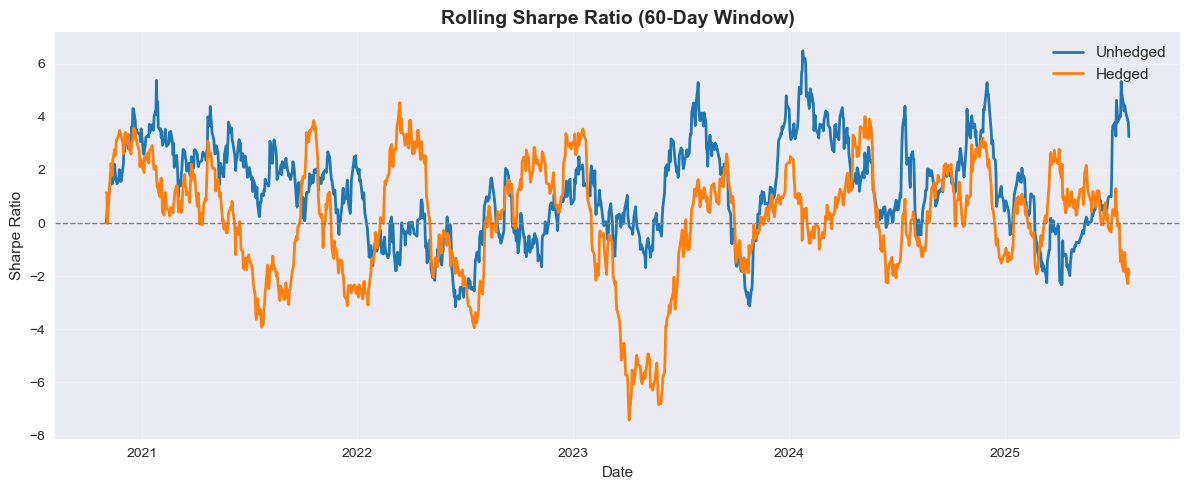

In [10]:
# Rolling Sharpe Ratio Visualization
window = 60
unhedged_returns = tc_data[unhedged_portfolio_value_col].pct_change()
hedged_returns = tc_data[hedged_portfolio_value_col].pct_change()
unhedged_rolling_sharpe = (
    (unhedged_returns.rolling(window).mean() / 
     unhedged_returns.rolling(window).std()) * np.sqrt(252)
)
hedged_rolling_sharpe = (
    (hedged_returns.rolling(window).mean() / 
     hedged_returns.rolling(window).std()) * np.sqrt(252)
)

plt.figure(figsize=(12, 5))
plt.plot(tc_data.index, unhedged_rolling_sharpe, 
         label='Unhedged', color='#1f77b4', linewidth=2)
plt.plot(tc_data.index, hedged_rolling_sharpe, 
         label='Hedged', color='#ff7f0e', linewidth=2)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.title(f'Rolling Sharpe Ratio ({window}-Day Window)', 
          fontsize=14, fontweight='bold')
plt.ylabel('Sharpe Ratio')
plt.xlabel('Date')
plt.legend(loc='upper right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Return Histograms with Skewness and Kurtosis Annotations

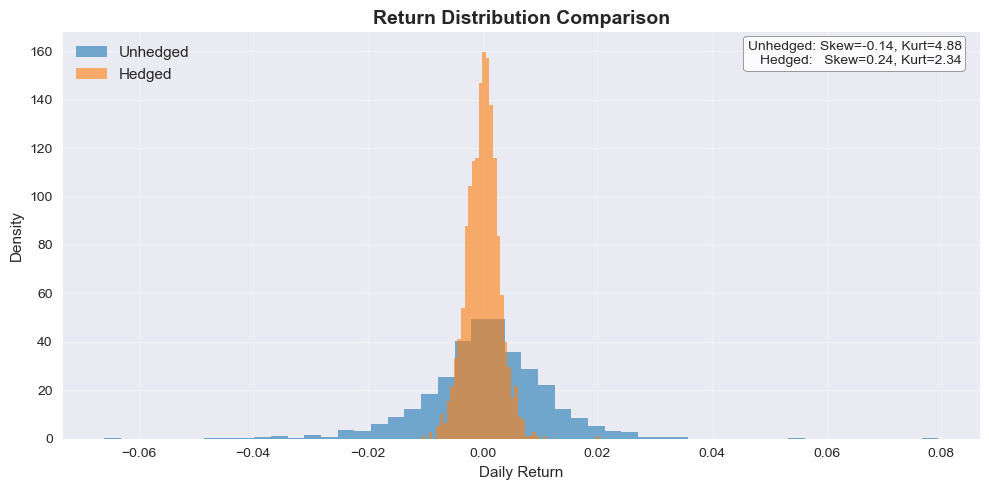

In [11]:
# Return Histograms with Skewness/Kurtosis Annotation
plt.figure(figsize=(10, 5))
bins = 50
plt.hist(unhedged_returns.dropna(), bins=bins, alpha=0.6, 
         label='Unhedged', color='#1f77b4', density=True)
plt.hist(hedged_returns.dropna(), bins=bins, alpha=0.6, 
         label='Hedged', color='#ff7f0e', density=True)
plt.title('Return Distribution Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

# Skewness and kurtosis annotation
unhedged_skew = unhedged_returns.skew()
hedged_skew = hedged_returns.skew()
unhedged_kurt = unhedged_returns.kurtosis()
hedged_kurt = hedged_returns.kurtosis()
annotation = (
    f"Unhedged: Skew={unhedged_skew:.2f}, Kurt={unhedged_kurt:.2f}\n"
    f"Hedged:   Skew={hedged_skew:.2f}, Kurt={hedged_kurt:.2f}"
)
plt.gca().text(0.98, 0.98, annotation, ha='right', va='top', fontsize=10,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.85),
               transform=plt.gca().transAxes)
plt.tight_layout()
plt.show()

### Time in Drawdown Graph

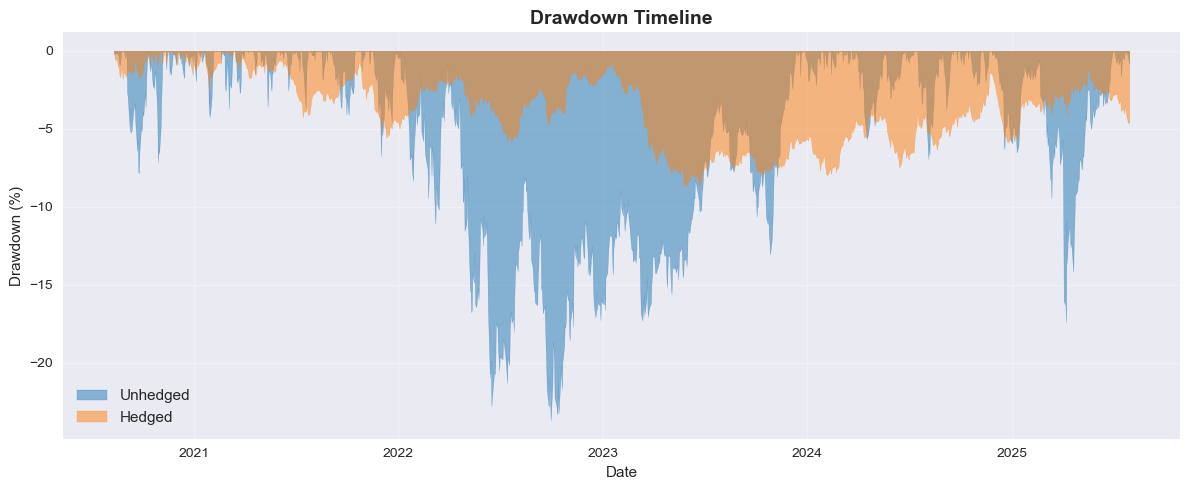

In [12]:
# Time in Drawdown Graph
def compute_drawdown_series(returns):
    cumret = (1 + returns).cumprod()
    roll_max = cumret.expanding().max()
    drawdown = (cumret / roll_max - 1) * 100
    return drawdown

unhedged_dd = compute_drawdown_series(unhedged_returns)
hedged_dd = compute_drawdown_series(hedged_returns)

plt.figure(figsize=(12, 5))
plt.fill_between(tc_data.index, unhedged_dd, 0, alpha=0.5, 
                 label='Unhedged', color='#1f77b4')
plt.fill_between(tc_data.index, hedged_dd, 0, alpha=0.5, 
                 label='Hedged', color='#ff7f0e')
plt.title('Drawdown Timeline', fontsize=14, fontweight='bold')
plt.ylabel('Drawdown (%)')
plt.xlabel('Date')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### VaR and CVaR Overlay

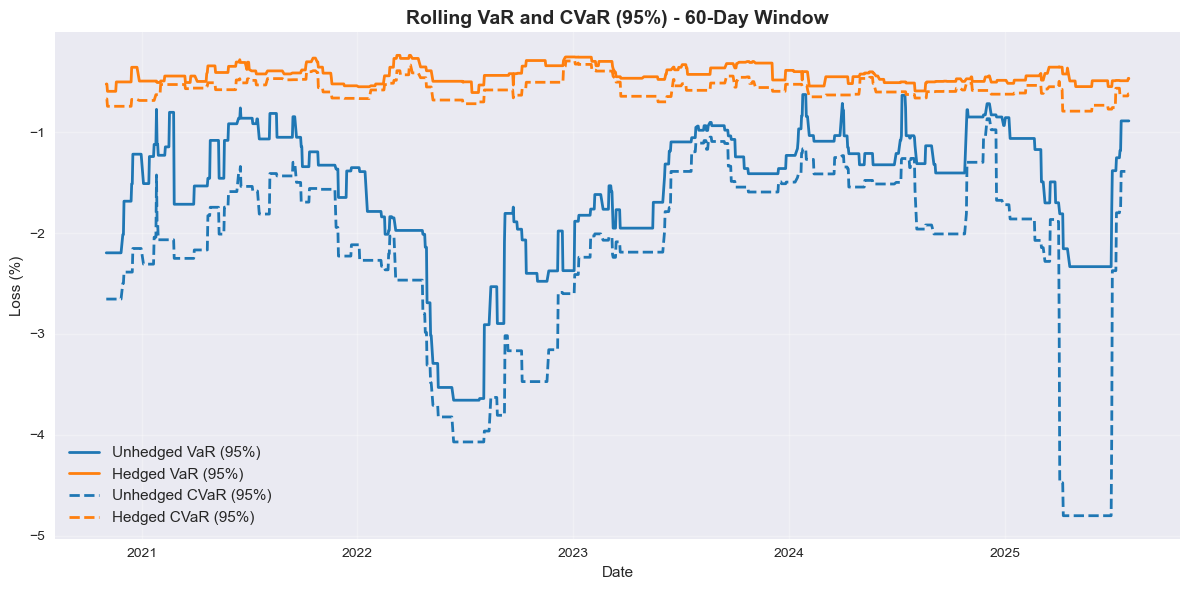

In [13]:
# VaR and CVaR Overlay
window = 60

def rolling_var(returns, window, alpha=0.05):
    return returns.rolling(window).quantile(alpha) * 100

def rolling_cvar(returns, window, alpha=0.05):
    def cvar_calc(x):
        var = x.quantile(alpha)
        return x[x <= var].mean()
    return returns.rolling(window).apply(cvar_calc, raw=False) * 100

unhedged_var = rolling_var(unhedged_returns, window)
hedged_var = rolling_var(hedged_returns, window)
unhedged_cvar = rolling_cvar(unhedged_returns, window)
hedged_cvar = rolling_cvar(hedged_returns, window)

plt.figure(figsize=(12, 6))
plt.plot(tc_data.index, 
         unhedged_var, 
         label='Unhedged VaR (95%)', 
         color='#1f77b4', linewidth=2)
plt.plot(tc_data.index, 
         hedged_var, 
         label='Hedged VaR (95%)', 
         color='#ff7f0e', linewidth=2)
plt.plot(tc_data.index, 
         unhedged_cvar, 
         label='Unhedged CVaR (95%)', 
         color='#1f77b4', linestyle='--', linewidth=2)
plt.plot(tc_data.index, 
         hedged_cvar, 
         label='Hedged CVaR (95%)', 
         color='#ff7f0e', linestyle='--', linewidth=2)
plt.title(f'Rolling VaR and CVaR (95%) - {window}-Day Window', fontsize=14, fontweight='bold')
plt.ylabel('Loss (%)')
plt.xlabel('Date')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

It's clear that the hedging strategy itself wasn't bad—it's the transaction costs that were the problem. The "Hedged" column, before the fees, shows the strategy was actually positive, with an Annualized Return of 0.32%. It's not a huge return, but it's not a huge loss either. When you look at the "Hedged (Net)" column with the -8.82% return, you can see how much those daily costs ate into the performance. The unhedged portfolio was good on its own (13.99% return), and the costs barely affected it (14.00% return). This really highlights that the 3 bps daily cost was a massive drag on the hedged strategy.

The hedged portfolio's Sharpe Ratio was 0.0717 before costs, which is pretty close to zero but not negative like the -1.5284 after costs. This means the strategy was *mostly* just breaking even on a risk-adjusted basis before the fees. It still doesn't beat the unhedged portfolio's Sharpe of 0.8167, but it's not a total disaster either.

The other metrics reinforce this. The **Maximum Drawdown** for the hedged portfolio was only -8.64% before costs, which is much better than the unhedged's -23.67%. The fact that the drawdown got so much worse after costs (to -38.19%) is wild and shows how those fees added up and created deeper losses. Also, the **Time in Drawdown** was 98.32% for the hedged portfolio before costs, which is high but understandable for a low-return, low-volatility strategy.

The **VaR** and **CVaR** numbers are also better for the hedged strategy before costs. VaR (95%) was -0.0048 and CVaR (95%) was -0.0060, both much smaller losses than the unhedged portfolio's -0.0170 and -0.0251. This confirms that even without the fees, the hedging strategy was doing a good job of protecting against those extreme, negative returns.

That the hedging strategy itself wasn't flawed in its design to reduce risk. It actually worked well for that purpose. The real issue was the high cost of implementation, which totally destroyed any positive return and turned the portfolio into a losing one.